In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import json

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

params = json.loads(open('../params.json', 'r').read())

# Date range
start = "2022-02-06"
end = "2024-02-06"

# Tickers of assets
industry_asset = json.loads(open('../stocks.json', 'r').read())
assets = []
for key, values in industry_asset.items():
    for value in values:
        assets.append(value)

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%%**********************]  23 of 23 completed


In [2]:
# Calculating returns

Y = data[assets].pct_change().dropna()

display(Y.tail())

,TIMS3.SA,VIVT3.SA,SUZB3.SA,KLBN11.SA,CSAN3.SA,VBBR3.SA,PRIO3.SA,UGPA3.SA,ENAT3.SA,PETR3.SA,...,ALUP11.SA,CPFE3.SA,CMIG3.SA,ELET3.SA,EQTL3.SA,EGIE3.SA,VALE3.SA,GGBR3.SA,CSNA3.SA,FESA4.SA
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-30,-0.8856%,0.1997%,-2.1038%,0.0548%,-0.9403%,-0.7426%,-1.6149%,-2.6777%,-0.5142%,-1.7619%,...,-0.7428%,-0.4485%,-1.4969%,2.5591%,-0.9247%,-1.7182%,-0.3938%,-0.5638%,1.4342%,-0.1962%
2024-01-31,0.0000%,-0.3322%,1.2001%,0.0548%,-1.0050%,1.1970%,1.4922%,0.1058%,0.6163%,2.4877%,...,-0.4209%,-0.0237%,-0.3629%,-0.9213%,0.0000%,1.0490%,1.2581%,-1.4830%,1.7566%,0.9434%
2024-02-01,1.5120%,1.1333%,0.5240%,1.5873%,-0.9024%,-0.8625%,1.9358%,-0.7400%,0.9682%,1.1290%,...,-0.8924%,1.8975%,-1.7755%,-1.0074%,1.6195%,1.9031%,1.0295%,-0.4575%,-1.1368%,2.0639%
2024-02-02,-1.2525%,-0.5933%,-2.2497%,-3.2866%,-2.5612%,-1.3174%,-2.2836%,-0.4260%,-0.6262%,-1.3955%,...,-0.4265%,-1.4665%,-1.6222%,0.4697%,-1.3236%,0.1698%,-2.8812%,-2.0311%,-0.6388%,-0.0191%
2024-02-05,0.3085%,0.3979%,0.7859%,0.7799%,1.4603%,1.2594%,0.4428%,0.5348%,-0.3938%,-0.3680%,...,0.8567%,0.0000%,-0.9423%,0.7986%,-0.6570%,1.0734%,1.9537%,-0.8626%,1.4145%,0.8968%


In [3]:
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

port.alpha = 0.05
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,TIMS3.SA,VIVT3.SA,SUZB3.SA,KLBN11.SA,CSAN3.SA,VBBR3.SA,PRIO3.SA,UGPA3.SA,ENAT3.SA,PETR3.SA,...,ALUP11.SA,CPFE3.SA,CMIG3.SA,ELET3.SA,EQTL3.SA,EGIE3.SA,VALE3.SA,GGBR3.SA,CSNA3.SA,FESA4.SA
weights,1.0906%,0.9183%,0.3464%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,14.2097%,...,0.0000%,25.2124%,3.4057%,0.0000%,0.0000%,22.4051%,10.8814%,0.0000%,0.0000%,0.0000%


In [4]:
assets_aux = []
industries = []
for k, v in industry_asset.items():
    assets_aux += v
    industries += len(v)*[k]
    
asset_classes = {'Assets': assets_aux, 
                 'Industry': industries}

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])

unique_industries = industry_asset.keys()

views = {'Disabled': len(unique_industries)*[False],
         'Type': len(unique_industries)*['Classes'],
         'Set': len(unique_industries)*['Industry'],
         'Position': list(unique_industries),
         'Sign': len(unique_industries)*['>='],
         'Weight': [0.02, 0.03, 0.04, 0.025, 0.035], # Annual terms
         'Type Relative': len(unique_industries)*['Classes'],
         'Relative Set': len(unique_industries)*['Industry'],
         'Relative': ['ElectricalEnergy', 'ElectricalEnergy', 'ElectricalEnergy', 'Minerals', 'ElectricalEnergy']}

views = pd.DataFrame(views)

display(views)

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative
0,False,Classes,Industry,Telecommunications,>=,2.0000%,Classes,Industry,ElectricalEnergy
1,False,Classes,Industry,PulpAndPaper,>=,3.0000%,Classes,Industry,ElectricalEnergy
2,False,Classes,Industry,OilGasBiofuelsExplorationRefiningEtc,>=,4.0000%,Classes,Industry,ElectricalEnergy
3,False,Classes,Industry,ElectricalEnergy,>=,2.5000%,Classes,Industry,Minerals
4,False,Classes,Industry,Minerals,>=,3.5000%,Classes,Industry,ElectricalEnergy


In [5]:
P, Q = rp.assets_views(views, asset_classes)

display(pd.DataFrame(P.T))
display(pd.DataFrame(Q))

,0,1,2,3,4
0,-11.1111%,-11.1111%,-11.1111%,11.1111%,-11.1111%
1,-11.1111%,-11.1111%,-11.1111%,11.1111%,-11.1111%
2,-11.1111%,-11.1111%,-11.1111%,11.1111%,-11.1111%
3,0.0000%,0.0000%,16.6667%,0.0000%,0.0000%
4,0.0000%,0.0000%,0.0000%,-25.0000%,25.0000%
5,-11.1111%,-11.1111%,-11.1111%,11.1111%,-11.1111%
6,-11.1111%,-11.1111%,-11.1111%,11.1111%,-11.1111%
7,0.0000%,0.0000%,16.6667%,0.0000%,0.0000%
8,-11.1111%,-11.1111%,-11.1111%,11.1111%,-11.1111%
9,-11.1111%,-11.1111%,-11.1111%,11.1111%,-11.1111%


,0
0,2.0000%
1,3.0000%
2,4.0000%
3,2.5000%
4,3.5000%


In [6]:
# Estimate Black Litterman inputs:

port.blacklitterman_stats(P, Q/252, rf=rf, w=w, delta=None, eq=True)

# Estimate optimal portfolio:

model='BL'# Black Litterman
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = False # Use historical scenarios for risk measures that depend on scenarios

w_bl = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

keys = w_bl.T.keys()
filtered_keys= []
w_bl_filtered_weights_raw = []
total_w_bl_filtered_weights = 0
for key in keys:
    if w_bl.T[key]["weights"] > 0.01:
        filtered_keys.append(key)
        w_bl_filtered_weights_raw.append(w_bl.T[key]["weights"])
        total_w_bl_filtered_weights += w_bl.T[key]["weights"]

w_bl_filtered_weights = pd.DataFrame([w_bl_filtered_weights_raw], columns=filtered_keys)
display(w_bl_filtered_weights)
print(f"Total: {total_w_bl_filtered_weights*100}")
print(f"Symbols: {[key for key in filtered_keys]}")

display(w_bl.T)

,PETR3.SA,TAEE11.SA,ALUP11.SA,CPFE3.SA,ELET3.SA,EGIE3.SA,VALE3.SA,FESA4.SA
0,12.2497%,20.9164%,4.3043%,22.3294%,5.1915%,25.3138%,6.8999%,1.8962%


Total: 99.1012113261543
Symbols: ['PETR3.SA', 'TAEE11.SA', 'ALUP11.SA', 'CPFE3.SA', 'ELET3.SA', 'EGIE3.SA', 'VALE3.SA', 'FESA4.SA']


,TIMS3.SA,VIVT3.SA,SUZB3.SA,KLBN11.SA,CSAN3.SA,VBBR3.SA,PRIO3.SA,UGPA3.SA,ENAT3.SA,PETR3.SA,...,ALUP11.SA,CPFE3.SA,CMIG3.SA,ELET3.SA,EQTL3.SA,EGIE3.SA,VALE3.SA,GGBR3.SA,CSNA3.SA,FESA4.SA
weights,0.0001%,0.0007%,0.0001%,0.0000%,0.0001%,0.0001%,0.0000%,0.0000%,0.0001%,12.2497%,...,4.3043%,22.3294%,0.2924%,5.1915%,0.0001%,25.3138%,6.8999%,0.3171%,0.0000%,1.8962%


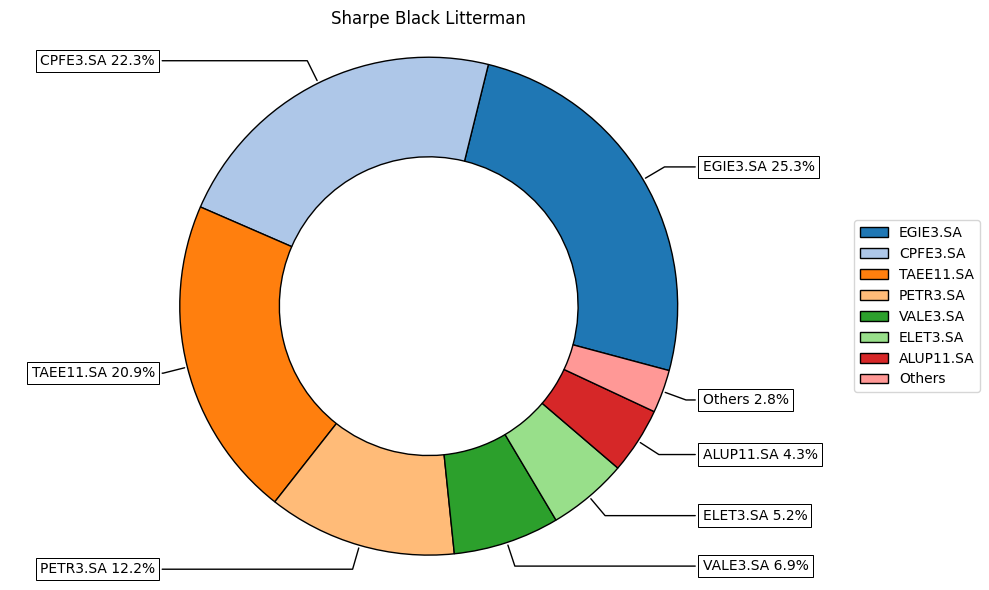

In [7]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w_bl, title='Sharpe Black Litterman', others=0.05, nrow=25,
                 cmap = "tab20", height=6, width=10, ax=None)

In [8]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,TIMS3.SA,VIVT3.SA,SUZB3.SA,KLBN11.SA,CSAN3.SA,VBBR3.SA,PRIO3.SA,UGPA3.SA,ENAT3.SA,PETR3.SA,...,ALUP11.SA,CPFE3.SA,CMIG3.SA,ELET3.SA,EQTL3.SA,EGIE3.SA,VALE3.SA,GGBR3.SA,CSNA3.SA,FESA4.SA
0,9.2777%,0.0000%,0.0000%,0.0000%,0.0000%,13.6417%,0.0000%,0.0000%,0.0000%,0.0000%,...,3.3652%,3.1962%,0.0208%,11.3640%,25.7753%,7.7312%,0.0000%,6.9004%,0.0000%,10.2585%
1,6.5389%,0.0000%,0.0000%,0.0000%,0.0000%,10.4343%,0.0000%,0.0000%,0.0000%,3.9887%,...,3.9024%,9.9712%,0.4073%,9.0991%,16.7313%,14.0762%,0.0000%,4.6664%,0.0000%,7.5173%
2,5.2177%,0.0000%,0.0000%,0.0000%,0.0000%,8.6908%,0.0000%,0.0000%,0.0000%,6.1353%,...,4.1326%,12.7509%,0.4834%,8.1736%,12.9063%,16.6452%,0.3489%,3.7706%,0.0000%,6.3471%
3,4.1930%,0.0000%,0.0000%,0.0000%,0.0000%,6.9105%,0.0000%,0.0000%,0.0000%,7.4104%,...,4.2208%,14.5995%,0.4417%,7.5839%,10.3220%,18.3244%,1.6185%,3.1296%,0.0000%,5.5556%
4,3.2944%,0.0000%,0.0000%,0.0000%,0.0000%,5.3504%,0.0000%,0.0000%,0.0000%,8.5261%,...,4.2970%,16.2183%,0.4054%,7.0682%,8.0612%,19.7947%,2.7317%,2.5676%,0.0000%,4.8623%


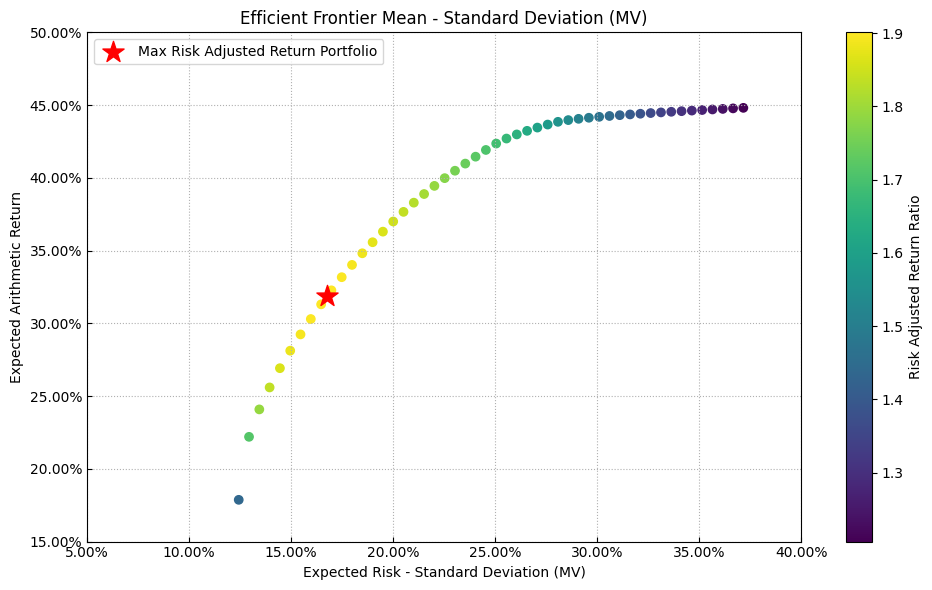

In [9]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu_bl # Expected returns of Black Litterman model
cov = port.cov_bl # Covariance matrix of Black Litterman model
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w_bl, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

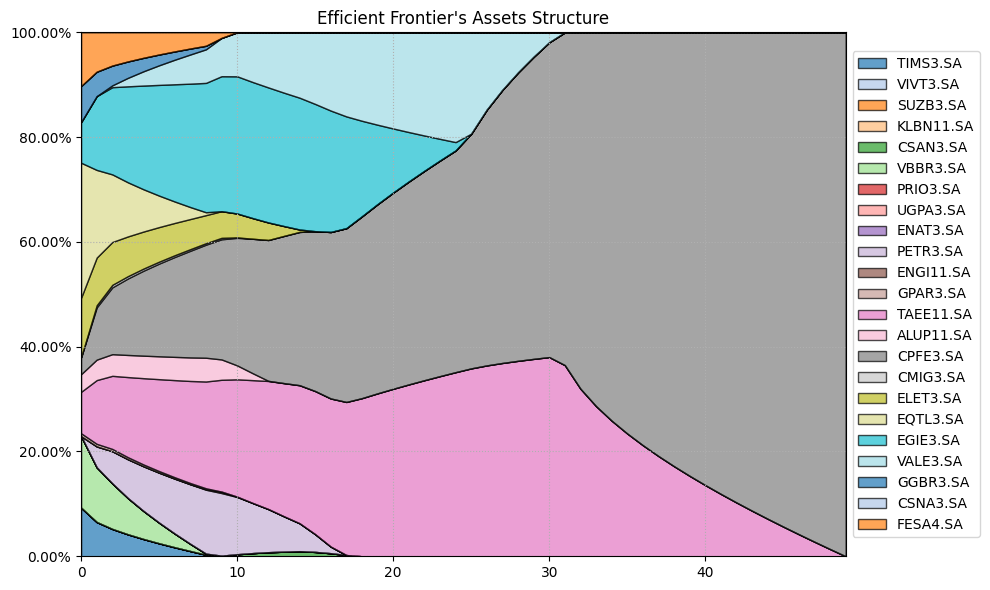

In [10]:
# Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

In [11]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI', 'EDaR']

w_s = pd.DataFrame([])
port.alpha = 0.05

for i in rms:
    if i == 'MV':
        hist = False
    else:
        hist = True
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')


,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,WR,MDD,ADD,CDaR,UCI,EDaR
TIMS3.SA,0.00%,0.15%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
VIVT3.SA,0.00%,0.00%,2.97%,0.00%,3.30%,5.60%,0.27%,4.01%,13.02%,4.96%,12.30%,9.30%,10.93%
SUZB3.SA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,3.23%,6.89%,4.19%,0.00%,6.28%,0.41%
KLBN11.SA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
CSAN3.SA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.32%,0.00%,0.00%,0.00%
VBBR3.SA,0.00%,0.00%,3.28%,0.00%,3.41%,0.00%,5.06%,0.00%,18.54%,0.82%,14.62%,8.21%,20.24%
PRIO3.SA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.55%,10.02%,0.21%,0.00%,6.28%,0.00%,4.70%
UGPA3.SA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,2.49%,13.49%,0.00%,0.00%,0.00%,0.00%,0.00%
ENAT3.SA,0.00%,0.00%,0.00%,0.00%,0.00%,8.94%,0.95%,0.54%,0.00%,0.00%,0.00%,0.00%,0.00%
PETR3.SA,12.25%,1.17%,8.18%,0.00%,8.25%,6.52%,11.57%,8.17%,0.00%,0.00%,0.00%,0.00%,0.00%


<Axes: >

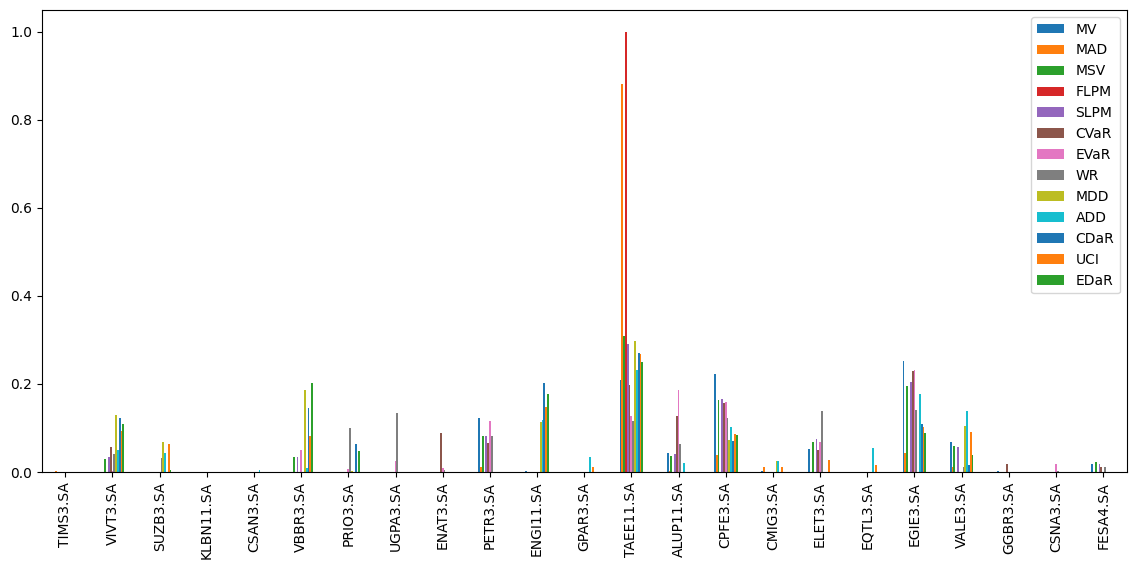

In [12]:
import matplotlib.pyplot as plt

# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(14)
fig.set_figheight(6)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)